In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk("./"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import pandas as pd
import torch
import torch.nn as nn
from scipy import stats

# 1. Frame the problem
Using the customer description, Define the problem your trying to solve in your own words (remember this is not technial but must be specific so the customer understands the project

Using the resources (templates, test code, research paper, etc.) provided, code an AI system to play the popular online game Tetris and to last for 60 seconds or more. It'll do so using a student-programmed algorithm to optimally detect strategic game moves, taking in data such as the current existing blocks, open blocks, the incoming block, etc. 


# 2. Get the Data 

Define how you recieved the data (provided, gathered..)

The data that will be fed into the system consist of a variety of input data taken from the ongoing game of tetris, including (but definitely not limited to):
- the current state of the game board, represented as a 2d numpy array
    - true values represent blank/unoccupied units, whereas false values represent occupied units (the Board object)
- the incoming piece that is being dropped
    - the Piece object is represented in 2 forms: its body and skirt
        - the body is an array of 4 2-value tuples representing cartesian coordinates. the left- and bottom-most grid in that piece is the origin; however, not all pieces have a piece at the origin. one prime example is the s2 block
        - the skirt is a list of integers representing the bottom profile of the piece. e.g, an unrotated s1 block would have a skirt of [0, 0, 1\]

this consists of the most basic and foundational parts of the input data; however, with different algorithms, different parts can be either determined through further column engineering.


# 3. Explore the Data
Gain insights into the data you have from step 2, making sure to identify any bias

i wasn't too sure what to "explore" besides board.py and piece.py. however, i did notice there was a csv file consisting of some sample data, so i decided to analyze this: 


In [5]:
sampledata_pd = pd.read_csv('src/data_0.csv')
print('columns:')
print(sampledata_pd.columns)
print('first 10 rows:\n')
sampledata_pd.head(10)

columns:
Index(['avg_fit', 'avg_gene', 'top_fit', 'top_gene', 'elite_fit', 'elite_gene',
       'top_rows'],
      dtype='object')
first 10 rows:



,avg_fit,avg_gene,top_fit,top_gene,elite_fit,elite_gene,top_rows
0,1.000000,[1. 1. 1. 1. 1. 1. 1. 1. 1.],1.000000,[1. 1. 1. 1. 1. 1. 1. 1. 1.],1.000000,[1. 1. 1. 1. 1. 1. 1. 1. 1.],1
1,16.566667,[-0.01234482 -0.0540228 -0.00230896 0.373692...,35.333333,[-0.16376679 0.24849196 -0.23668603 -0.187009...,35.333333,[-0.16376679 0.24849196 -0.23668603 -0.187009...,0
2,24.166667,[-0.46238923 -0.01471711 0.46841671 -0.165898...,41.000000,[-0.14374126 0.21087637 -0.19438047 -0.135959...,41.000000,[-0.14374126 0.21087637 -0.19438047 -0.135959...,0
3,41.966667,[-0.16583153 0.2423745 -0.19758663 -0.160888...,122.666667,[-0.17583948 0.32518887 -0.27819081 -0.283365...,122.666667,[-0.17583948 0.32518887 -0.27819081 -0.283365...,0
4,48.533333,[-0.13996796 0.23035997 -0.2216404 -0.167234...,128.333333,[-0.17583948 0.32518887 -0.27819081 -0.283365...,128.333333,[-0.17583948 0.32518887 -0.27819081 -0.283365...,0
5,60.333333,[-0.140487 0.2394328 -0.24637719 -0.194756...,142.333333,[-0.15716924 0.19127002 -0.24040054 -0.301237...,142.333333,[-0.15716924 0.19127002 -0.24040054 -0.301237...,0
6,73.466667,[-0.14573147 0.19397704 -0.21879767 -0.302622...,204.000000,[-0.09174044 0.19084142 -0.23427464 -0.217524...,204.000000,[-0.09174044 0.19084142 -0.23427464 -0.217524...,0
7,164.400000,[-0.11940614 0.22074441 -0.2133096 -0.240825...,456.666667,[-0.16100453 0.32934755 -0.24160425 -0.208544...,456.666667,[-0.16100453 0.32934755 -0.24160425 -0.208544...,0
8,214.000000,[-0.10751983 0.20871911 -0.24285469 -0.179429...,433.333333,[-0.16100453 0.32934755 -0.24160425 -0.208544...,433.333333,[-0.16100453 0.32934755 -0.24160425 -0.208544...,0
9,432.200000,[-0.14237597 0.29793459 -0.28634022 -0.184384...,1376.000000,[-0.16240016 0.37880136 -0.35563937 -0.208716...,1376.000000,[-0.16240016 0.37880136 -0.35563937 -0.208716...,0


In [6]:
cols = ['alg', 'run_duration', 'pieces_dropped', 'rows cleared', 'trial_num'] 

data_1 = pd.DataFrame(columns=cols)

In [11]:
# random
!python src/main.py random >> game_logs/random_log1.txt 

with open('game_logs/random_log1.txt', 'r') as f:
    cont = f.read() 
    line1 = cont.splitlines()[-2] 
    line2 = cont.splitlines()[-1]
    
    i1 = line1.find('pieces dropped: ')
    end = line1.find(',', i1)  
    pieces = line1[i1 + len('pieces dropped: '):end].strip()
    
    i2 = line1.find('rows cleared: ')
    rows = line1[i2 + len('rows cleared: '):].strip()

    i3 = line2.find('duration: ')
    duration = line2[i3 + len('duration: '):].strip() 

data_1.loc[len(data_1)] = ['random', duration, pieces, rows, 1]

# genetic
!python src/main.py genetic >> game_logs/genetic_log1.txt 

with open('game_logs/genetic_log1.txt', 'r') as f:
    cont = f.read() 
    line1 = cont.splitlines()[-2] 
    line2 = cont.splitlines()[-1]
    
    i1 = line1.find('pieces dropped: ')
    end = line1.find(',', i1)  
    pieces = line1[i1 + len('pieces dropped: '):end].strip()
    
    i2 = line1.find('rows cleared: ')
    rows = line1[i2 + len('rows cleared: '):].strip()

    i3 = line2.find('duration: ')
    duration = line2[i3 + len('duration: '):].strip() 

data_1.loc[len(data_1)] = ['genetic', duration, pieces, rows, 1]

# greedy
!python src/main.py greedy >> game_logs/greedy_log1.txt 

with open('game_logs/greedy_log1.txt', 'r') as f:
    cont = f.read() 
    line1 = cont.splitlines()[-2] 
    line2 = cont.splitlines()[-1]
    
    i1 = line1.find('pieces dropped: ')
    end = line1.find(',', i1)  
    pieces = line1[i1 + len('pieces dropped: '):end].strip()
    
    i2 = line1.find('rows cleared: ')
    rows = line1[i2 + len('rows cleared: '):].strip()

    i3 = line2.find('duration: ')
    duration = line2[i3 + len('duration: '):].strip() 

data_1.loc[len(data_1)] = ['greedy', duration, pieces, rows, 1]

# mcts
!python src/main.py mcts >> game_logs/mcts_log1.txt 

with open('game_logs/mcts_log1.txt', 'r') as f:
    cont = f.read() 
    line1 = cont.splitlines()[-2] 
    line2 = cont.splitlines()[-1]
    
    i1 = line1.find('pieces dropped: ')
    end = line1.find(',', i1)  
    pieces = line1[i1 + len('pieces dropped: '):end].strip()
    
    i2 = line1.find('rows cleared: ')
    rows = line1[i2 + len('rows cleared: '):].strip()

    i3 = line2.find('duration: ')
    duration = line2[i3 + len('duration: '):].strip() 

data_1.loc[len(data_1)] = ['mcts', duration, pieces, rows, 1]


In [13]:
data_1.head(4)

algs = data_1['alg'] 
rows = data_1['rows cleared'] 
pieces = data_1['pieces_dropped'] 


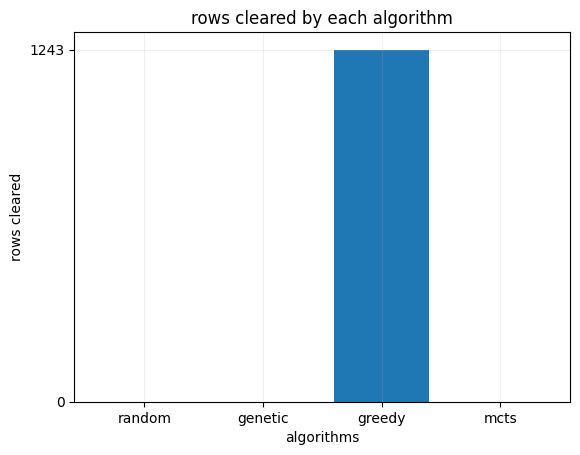

In [18]:
plt.bar(algs, rows)
plt.xlabel('algorithms')
plt.ylabel('rows cleared') 
plt.title('rows cleared by each algorithm')
plt.grid(True, alpha=0.2)
plt.show()

# 4. Prepare the Data

Apply any data transformations and explain what and why

in order to make our custom model to train an algorithm on playing tetris, we'd have to:
- take in the current state of the board (Board object)
- take in the next piece (Piece object)
- along some other engineered features that we'll have to determine uniquely for each algorithm

In [13]:
with open('custom_model.py', 'r') as f:
    contents = f.read()
    print(contents)

from copy import copy, deepcopy
import numpy as np
import pygame
from piece import BODIES, Piece
from board import Board
from random import randint

"""
Add your code here 
"""

class CUSTOM_AI_MODEL:
    def __init__(self):
        pass

    def get_best_move(self, board, piece, depth=1):
        i = 1
        best_x = 0
        best_piece = piece

        # random rotation
        for x in range(randint(0, 3)):
            best_piece = piece.get_next_rotation()

        # random location, we need to make sure it falls in the field of play
        for x in range(board.width):
            best_x = randint(0, board.width - i)
            try:
                y = board.drop_height(best_piece, best_x)
                print("IN Play i : {} y: {}".format(i, y))
                break
            except Exception as e:
                print(e)
                # import IPython
                # IPython.embed()
                print("OUT of PLAY")
                i += 1

        print("best_x {

# 5. Model the data 
Using selected ML models, experment with your choices and describe your findings. Finish by selecting a Model to continue with


for my custom model, i decided to implement a straightforward neural network feeding in 9 features (the same features used in the default genetic.py program) with only 1 hidden layer (16 neurons), consisting of a total of 3 layers. then, i combined this with the genetic algorithm

In [30]:
with open('src/custom_model.py', 'r') as f:
    contents = f.read()
    print(contents)

from copy import copy, deepcopy
import numpy as np
import pygame
import torch
from piece import BODIES, Piece
from board import Board
from random import randint
from genetic_helpers import *

"""
Add your code here 
"""

class NeuralNetwork: 
    def __init__(self, input_size=9, hidden_size=16, weights=None, device='cpu'):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.device = device 

        if weights is None:
            # xavier initialization for weights
            lim1 = np.sqrt(6 / (input_size + hidden_size))
            lim2 = np.sqrt(6 / (hidden_size + 1))

            self.W1 = torch.FloatTensor(input_size, hidden_size).uniform_(-lim1, lim1).to(device)
            self.W2 = torch.FloatTensor(hidden_size, 1).uniform_(-lim2, lim2).to(device)

            self.b1 = torch.zeros(hidden_size, device=device)
            self.b2 = torch.zeros(1, device=device)

        else:
            # reconstruct from flattened like in typical genetic 

In [31]:
with open('src/custom_controller.py', 'r') as f:
    contents = f.read()
    print(contents)

import numpy as np
from game import Game
from custom_model import CUSTOM_AI_MODEL
import random
import pandas as pd
import os
import torch
from gpu_utils import setup_device, print_gpu_status

def compute_fitness(agent, num_trials=3):
    fitness_scores = []
    pieces = []
    rows = []

    for trial in range(num_trials):
        game = Game('student', agent=agent)
        p_dropped, rows_cleared = game.run_no_visual()

        fitness = p_dropped + (rows_cleared * 2.0)
        fitness_scores.append(fitness)

        pieces.append(p_dropped)
        rows.append(rows_cleared)

        print(f"      trial {trial+1}/{num_trials}: pieces={p_dropped}, rows={rows_cleared}, fitness={fitness:.2f}")

    avg_fitness = np.mean(fitness_scores)
    avg_pieces = np.mean(pieces)
    avg_rows = np.mean(rows)

    return avg_fitness, avg_pieces, avg_rows


def crossover(parent1, parent2, device='cpu'):
    ws1 = parent1.get_genotype()
    ws2 = parent2.get_genotype()

    i = random.randint(1, len(w

In [23]:
!python -u src/custom_controller.py

pygame 2.6.1 (SDL 2.28.4, Python 3.12.6)
Hello from the pygame community. https://www.pygame.org/contribute.html
TRAINING NEURAL NETWORK
generations: 50
pop. size: 20
trials per agent: 7
elite agents: 3
surv rate: 0.15
continue from checkpoint: True

GPU Status Report
GPU   Name                 Memory Used     Memory Total    GPU Util  
----------------------------------------------------------------------
0     Tesla V100S-PCIE-32GB   1546 MB        32768 MB         0%
1     Tesla V100S-PCIE-32GB      6 MB        32768 MB         0%
2     Tesla V100S-PCIE-32GB      6 MB        32768 MB         0%
3     Tesla V100S-PCIE-32GB      6 MB        32768 MB         0%
4     Tesla V100S-PCIE-32GB      6 MB        32768 MB         0%
5     Tesla V100S-PCIE-32GB      4 MB        32768 MB         0%
6     Tesla V100S-PCIE-32GB      4 MB        32768 MB         0%

Selected GPU 0: 32501MB free out of 32501MB
Device set to: cuda:0
GPU Name: Tesla V100S-PCIE-32GB

loading checkpoint from src/custom_

# 6. Fine Tune the Model

With the select model descibe the steps taken to acheve the best rusults possiable 


although i did not perform any formal fine-tuning, here were some parameters and various other things i tweaked around during the training process of this model:
- i initially implemented an adaptive online learning feature that would attempt to adapt if performance was declining in testing
    - however, after the first round of training, testing showed that this would actually ruin the weights; this resulted in performance that steadily declined one test trial after another
- i also initially used different parameters for training, which were:
    - 30 generations
    - 20 agents in each
    - 3 trials per agent
    - 30% survival rate
    - 15% mutation rate and 0.3 mutation scale
- and there were various issues with these, including:
    - too few generations, and too few agents per generation
    - too little trials to accurately determine whether an agent got lucky or is actually effective
    - survival rate was too high
    - mutation rate and scale were both too high, resulting in good weights being erased

### to visualize just how subpar my first trial went:

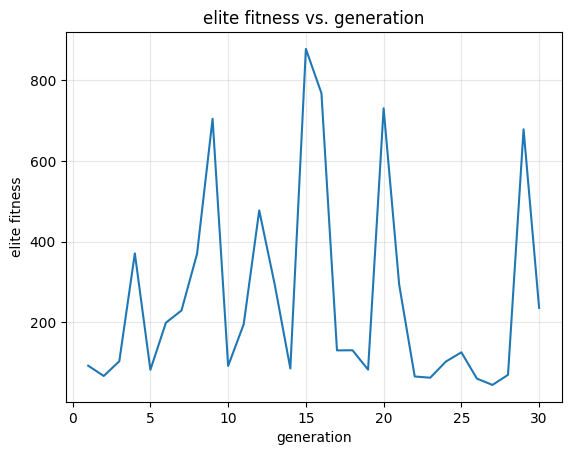

In [34]:
df = pd.read_csv('src/custom_data/custom_trial1.csv')

plt.plot(df['generation'], df['elite_fitness'])
plt.xlabel('generation')
plt.ylabel('elite fitness')
plt.title('elite fitness vs. generation')
plt.grid(True, alpha=0.3)

plt.show()

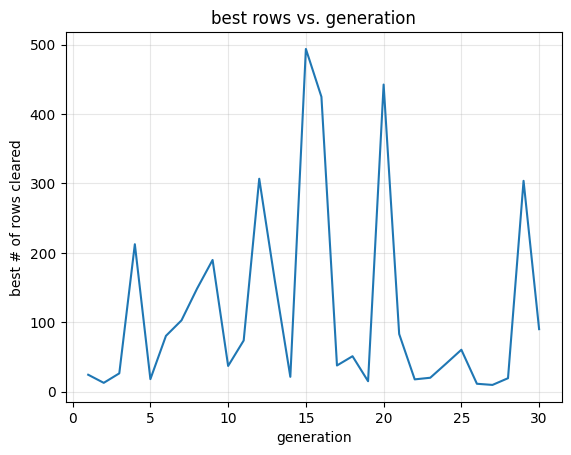

In [36]:
plt.plot(df['generation'], df['best_rows'])
plt.xlabel('generation')
plt.ylabel('best # of rows cleared')
plt.title('best rows vs. generation')
plt.grid(True, alpha=0.3)

plt.show()

## same went for training trial #3...

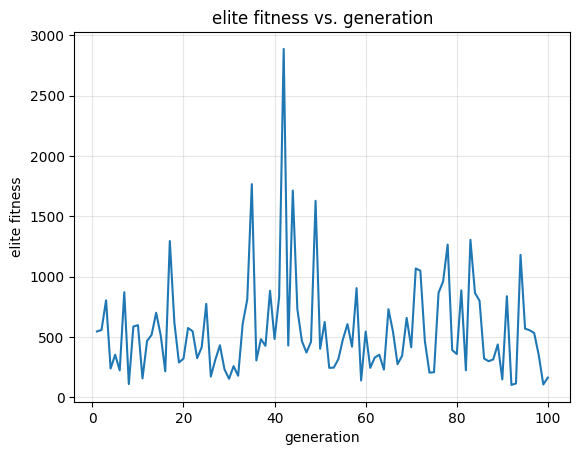

In [40]:
df = pd.read_csv('src/custom_data/custom_trial3.csv')

plt.plot(df['generation'], df['elite_fitness'])
plt.xlabel('generation')
plt.ylabel('elite fitness')
plt.title('elite fitness vs. generation')
plt.grid(True, alpha=0.3)

plt.show()

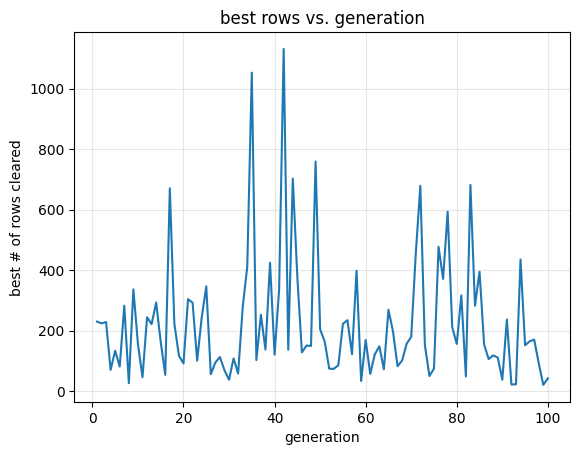

In [41]:
plt.plot(df['generation'], df['best_rows'])
plt.xlabel('generation')
plt.ylabel('best # of rows cleared')
plt.title('best rows vs. generation')
plt.grid(True, alpha=0.3)

plt.show()

# 7. Present
In a customer faceing Document provide summery of finding and detail approach taken

### the architecture of the fnn is rather simplistic: 
- 3 layers total (may adjust later if necessary) with 9 inputs, 1 hidden layer (16 neurons), and 1 output
- leaky relu activation (alpha = 0.01)
- feature normalization
- xavier initialization of weights
- total of 177 trainable params (9*16 + 16 + 16 + 1)

### then, the genetic algorithm: (based off of existing genetic algorithm)
- flattened nn weights as chromosome representation
- top 3 (adjustable) agents ("elite") and fitness-based parent selection from population's top 15% (adjustable)
- single-point crossover on weight vectors
- mutations repped with gaussian noise (10% mutation rate, sigmax = 0.1)

### training:
- 50 generations, each w 30 agents
- 7 trials per agent (avg fitness score was used)

### final results:
- training took ~24 hours (only counting final training session)
    - previous attempts at training were made (probably another 12-24 hrs cumulative) but were either aborted or dismissed due to errors in code 
- final best weights were saved from the agent with the highest ever fitness score (~4019)
    - 2183 pieces, 918 rows

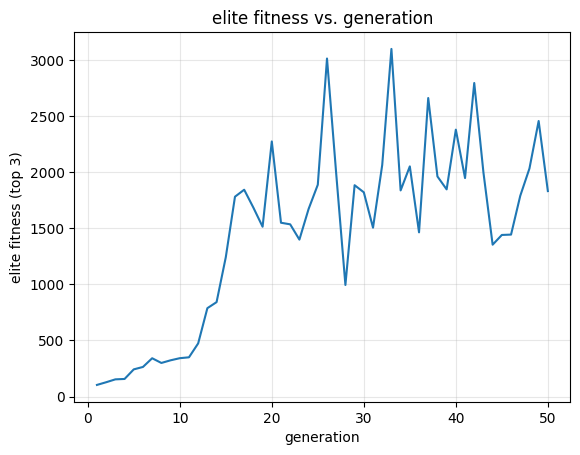

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('src/custom_data/custom_trial5.csv')

plt.plot(df['generation'], df['elite_fitness'])

plt.xlabel('generation')
plt.ylabel('elite fitness (top 3)')
plt.title('elite fitness vs. generation')
plt.grid(True, alpha=0.3)

plt.show()

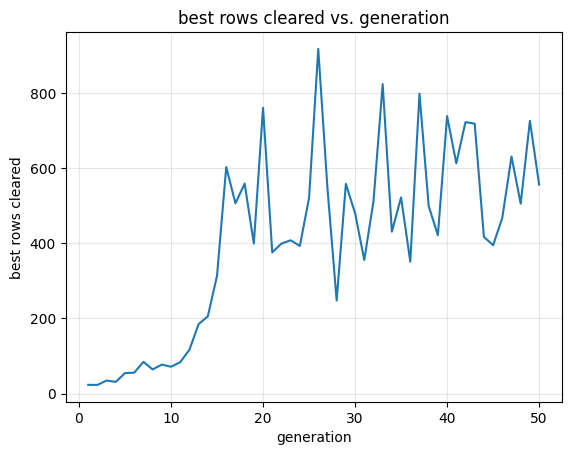

In [33]:
plt.plot(df['generation'], df['best_rows'])
plt.xlabel('generation',)
plt.ylabel('best rows cleared',)
plt.title('best rows cleared vs. generation')
plt.grid(True, alpha=0.3)

plt.show()

# 8. Launch the Model System
Define your production run code, This should be self sufficient and require only your model pramaters 


In [38]:
# first, make sure that main.py is using run_no_visual

with open('src/main.py', 'r') as f:
    contents = f.read()
    print(contents)

from game import Game
import sys
import os
import time

def main():
    # textfile = open("./src/data/expectiminimax/10.csv", "w")
    # textfile.write("dropped, rows\n")
    # for i in range(2):
    #     print(i)
    #     g = Game(sys.argv[1])
    #     dropped, rows = g.run_no_visual()
    #     textfile.write(str(dropped) + ", " + str(rows) + "\n")
    # textfile.close()
    g = Game(sys.argv[1])
    start = time.time() 
    g.run_no_visual()
    # g.run()
    end = time.time() 
    dur = end - start
    print(f'duration: {dur}')
    

    # for a visual, comment out line 16 and uncomment line 17 


if __name__ == "__main__":
    main()



In [3]:
!python src/main.py student

pygame 2.6.1 (SDL 2.28.4, Python 3.12.6)
Hello from the pygame community. https://www.pygame.org/contribute.html
starting game!
total pieces dropped: 310, total rows cleared: 116
duration: 5.3872363567352295 seconds
